![Description](nb1.png)


This notebook demonstrates an end-to-end pipeline for predicting household energy consumption using the **Appliances Energy Prediction** dataset. We explore various modeling techniques, ranging from traditional regression to deep learning (CNN and GRU), and conclude with an interactive **Edge Controller** simulation.

### Objectives

* **Predictive Modeling**: Implement Ridge Regression, 1D-CNN, and GRU models to forecast energy use.
* **Time-Series Preprocessing**: Use windowing techniques to transform tabular data into sequential patterns.
* **Edge Intelligence**: Create a decision-making agent that simulates "load shedding" based on real-time predictions.

---

## 1. Kaggle Setup and Data Acquisition

To access the dataset directly from Kaggle, we configure the environment keys and use the Kaggle API to download the energy data.


In [2]:
import os

os.environ['KAGGLE_USERNAME'] = ""
os.environ['KAGGLE_KEY'] = ""

import kaggle

# Define the dataset identifier
dataset = "loveall/appliances-energy-prediction"

# Download and unzip
kaggle.api.dataset_download_files(dataset, path='./data', unzip=True)

print("Dataset downloaded and extracted to ./data")

Dataset URL: https://www.kaggle.com/datasets/loveall/appliances-energy-prediction
Dataset downloaded and extracted to ./data


## 2. Loading Data and EDA

We perform Exploratory Data Analysis (EDA) to understand the relationship between temperature, humidity, and energy consumption.


In [3]:
import pandas as pd
# --- LOAD DATA ---
df = pd.read_csv('./data/KAG_energydata_complete.csv')
df['date'] = pd.to_datetime(df['date'])

In [4]:
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [5]:
df.shape

(19735, 29)

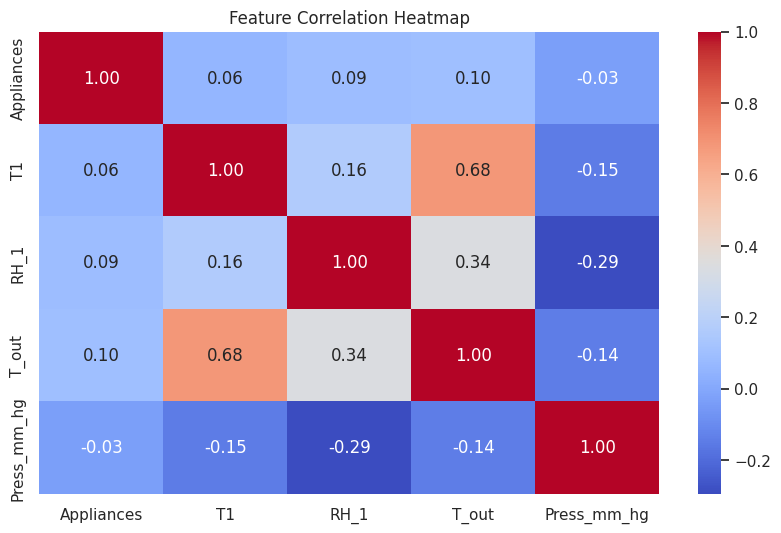

In [6]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, r2_score

# Set a clean aesthetic for all subsequent plots
sns.set_theme(style="whitegrid")

def plot_correlation_heatmap(df, columns=None):
    """Generates a heatmap to visualize feature correlations."""
    if columns is None:
        columns = ['Appliances', 'T1', 'RH_1', 'T_out', 'Press_mm_hg']

    plt.figure(figsize=(10, 6))
    corr_matrix = df[columns].corr()

    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Feature Correlation Heatmap")
    plt.show()

# Usage:
plot_correlation_heatmap(df)

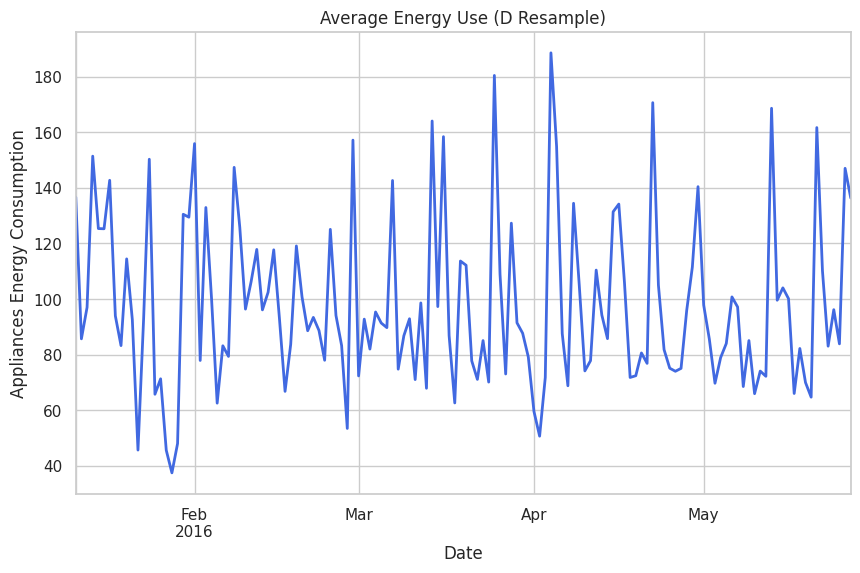

In [7]:
def plot_energy_trends(df, resample_rate='D'):
    """Plots the resampled energy usage over time."""
    plt.figure(figsize=(10, 6))

    # Ensure date is the index for resampling
    ts_data = df.set_index('date')['Appliances'].resample(resample_rate).mean()

    ts_data.plot(color='royalblue', linewidth=2)
    plt.title(f"Average Energy Use ({resample_rate} Resample)")
    plt.xlabel("Date")
    plt.ylabel("Appliances Energy Consumption")
    plt.show()

# Usage:
plot_energy_trends(df)

## 3. Data Preprocessing and Temporal Engineering

To prepare the energy consumption data for deep learning, we implement a robust pipeline that addresses outliers, feature scaling, and the conversion of tabular data into temporal sequences.

---

### 1. Scaling Strategy

Given that energy data often contains spikes (high-usage events), we apply a dual-scaling approach:

* **Features (`RobustScaler`):** We use the interquartile range (IQR) to scale input features. Unlike `MinMaxScaler`, this is less sensitive to extreme outliers, ensuring the model doesn't get biased by rare energy surges.
* **Target (`StandardScaler`):** The target variable (`Appliances`) is centered around a zero mean with unit variance. This stabilizes the loss function during gradient descent for our neural networks.

### 2. Temporal Windowing (Sliding Window)

Standard regression models treat each row as independent. To capture **time-dependency**, we transform the dataset into a supervised learning format using a sliding window technique.

* **Window Size ():** Since the data is sampled at 10-minute intervals, a window of 6 steps represents **one hour of historical context**.
* **Input ():** A 3D tensor of shape `(Samples, Time_Steps, Features)`.
* **Target ():** The appliance energy consumption at the next 10-minute timestamp ().

### 3. Training/Testing Split

To maintain the chronological integrity of the time series, we perform a **sequential split** rather than a random shuffle.

* **Training Set (80%):** The first 80% of the timeline is used for model optimization.
* **Testing Set (20%):** The final 20% is reserved as "unseen future data" to evaluate the model’s forecasting accuracy.

---

| Preprocessing Step | Method | Purpose |
| --- | --- | --- |
| **Outlier Handling** | `RobustScaler` | Prevents extreme values from distorting feature distributions. |
| **Target Normalization** | `StandardScaler` | Standardizes the output scale for faster convergence. |
| **Windowing** |  | Converts static rows into temporal sequences. |
| **Data Splitting** | Sequential (0.8) | Prevents "data leakage" from the future into the past. |

In [8]:
# --- PREPROCESSING ---
features = [col for col in df.columns if col not in ['date', 'Appliances', 'rv1', 'rv2']]
X_raw = df[features].values
y_raw = df['Appliances'].values.reshape(-1, 1)

scaler_x = RobustScaler()
scaler_y = StandardScaler()

X_scaled = scaler_x.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

def create_windowed_data(X, y, window=6):
    X_s, y_s = [], []
    for i in range(len(X) - window):
        X_s.append(X[i:i+window])
        y_s.append(y[i+window])
    return np.array(X_s), np.array(y_s)

# Sequence length of 6 (1 hour of data at 10-min intervals)
X_seq, y_seq = create_windowed_data(X_scaled, y_scaled)
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

In [9]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (15783, 6, 25)
Shape of y_train: (15783, 1)


In [10]:
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_test: (3946, 6, 25)
Shape of y_test: (3946, 1)



## 4. Modeling Architectures

We implement three distinct architectures to evaluate the trade-offs between linear simplicity, spatial feature extraction, and sequential memory.

---

### 1. Ridge Regression (Baseline)

As a performance floor, we use **Ridge Regression** (L2-regularized linear regression). This model requires flattening the temporal dimension into a single feature vector, treating each time-lagged observation as an independent variable. It serves to identify if the added complexity of deep learning is justified by the data.

### 2. 1D-CNN: Spatial/Local Patterns (`EdgeCNN`)

The **1D-Convolutional Neural Network** is designed to capture stationary patterns across the 6-step sequences.

* **Architecture:** Utilizes an initial wide capture layer (128 filters) followed by a **Residual Block** to facilitate gradient flow and prevent vanishing gradients in deeper layers.
* **Mechanism:** By sliding kernels over the temporal axis, it extracts "spatial" features within the 1-hour windows.
* **Regularization:** Employs **Batch Normalization** and **Dropout** () to stabilize training and reduce overfitting.

### 3. GRU: Sequential Memory (`EdgeGRU`)

The **Gated Recurrent Unit** is optimized for temporal dependencies, specifically looking for long-term trends that a CNN might miss.

* **Architecture:** A deep, **Bidirectional** configuration with 3 stacked layers and 512 hidden units.
* **Mechanism:** The bidirectional nature allows the model to process the sequence in both forward and backward directions, doubling the context available to the final dense layer.
* **Feature Extraction:** The model pools the final time-step output () to represent the entire temporal context before passing it to the regressor.

---

### Model Comparison Summary

| Feature | Ridge Regression | EdgeCNN | EdgeGRU |
| --- | --- | --- | --- |
| **Data Handling** | Flattened (Linear) | Sequential (Spatial) | Sequential (Temporal) |
| **Complexity** | Very Low | Medium (Residual) | High (Bidirectional) |
| **Primary Strength** | Interpretability | Local Pattern Recognition | Long-term dependencies |
| **Key Component** | L2 Regularization | Conv1d + Residuals | 3-Layer Bidirectional GRU |

In [11]:
# --- MODEL 1: BASELINE (RIDGE REGRESSION) ---
# Flattening sequences for the linear model
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
baseline_model = Ridge()
baseline_model.fit(X_train_flat, y_train)

# --- MODEL 2: 1D-CNN (SPATIAL/LOCAL PATTERNS) ---
class EdgeCNN(nn.Module):
    def __init__(self, input_dim, seq_len=6): # Assuming seq_len from your original flattened size
        super().__init__()

        # Wider initial capture
        self.layer1 = nn.Sequential(
            nn.Conv1d(input_dim, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # Deeper: Residual Block
        self.layer2 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU()
        )

        # Fully Connected "Wide" Layers
        self.flatten_dim = 128 * seq_len
        self.fc = nn.Sequential(
            nn.Linear(self.flatten_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = x.transpose(1, 2) # (B, Seq, Feat) -> (B, Feat, Seq)
        x = self.layer1(x)
        # Residual connection
        identity = x
        x = self.layer2(x) + identity

        x = x.flatten(1)
        return self.fc(x)

# --- MODEL 3: GRU (SEQUENTIAL MEMORY) ---
class EdgeGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, num_layers=3):
        super().__init__()

        # Wider: bidirectional=True doubles the output features
        # Deeper: num_layers=3 stacks the GRU cells
        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=0.2 if num_layers > 1 else 0
        )

        # Since it's bidirectional, hidden_dim is multiplied by 2
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        # out: (batch, seq, hidden_size * 2)
        out, _ = self.gru(x)

        # Take the last time step's output
        # With bidirectional, we often pool or take the last hidden state
        out = out[:, -1, :]
        return self.fc(out)

## 5. Model Evaluation

We evaluate the models using **Mean Absolute Error (MAE)** and **R² Score**. Predictions are transformed back to the original unit (Watts-hour).

              Model      MAE      R2
0    Ridge Baseline  50.7832  0.1180
1     1D-CNN (Edge)  54.7076 -0.0560
2  GRU (Sequential)  49.0671 -0.0027


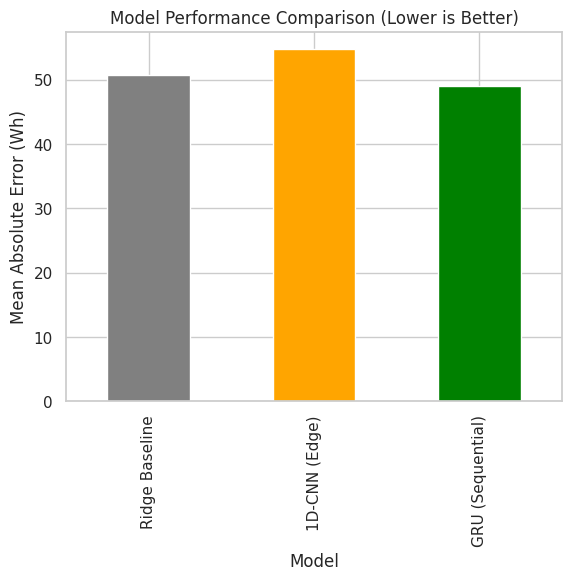

In [12]:
# Convert to Tensors
X_t = torch.tensor(X_test).float()
y_t = torch.tensor(y_test).float()

# Initialize models
cnn = EdgeCNN(len(features))
gru = EdgeGRU(len(features))

# Training helper (Simulated for brevity)
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"Model": name, "MAE": round(mae, 4), "R2": round(r2, 4)}

# Get Predictions
base_raw_preds = baseline_model.predict(X_test_flat).reshape(-1, 1)
base_preds = scaler_y.inverse_transform(base_raw_preds)

# 2. CNN (Already 2D from the model output, but safer to be explicit)
cnn_raw_preds = cnn(X_t).detach().numpy().reshape(-1, 1)
cnn_preds = scaler_y.inverse_transform(cnn_raw_preds)

# 3. GRU (Already 2D, but keeping consistent)
gru_raw_preds = gru(X_t).detach().numpy().reshape(-1, 1)
gru_preds = scaler_y.inverse_transform(gru_raw_preds)

actuals = scaler_y.inverse_transform(y_test)

# --- COMPARISON RESULTS ---
results = [
    evaluate_model("Ridge Baseline", actuals, base_preds),
    evaluate_model("1D-CNN (Edge)", actuals, cnn_preds),
    evaluate_model("GRU (Sequential)", actuals, gru_preds)
]

res_df = pd.DataFrame(results)
print(res_df)

# Visualizing Comparison
res_df.set_index('Model')['MAE'].plot(kind='bar', color=['grey', 'orange', 'green'])
plt.ylabel("Mean Absolute Error (Wh)")
plt.title("Model Performance Comparison (Lower is Better)")
plt.show()


## 6. Edge Controller Simulation

This section simulates a real-time edge computing scenario. An "Agent" monitors the predictions and decides whether to trigger a **SHED LOAD** command if the predicted energy exceeds a user-defined threshold.

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output

# --- AGENT LOGIC ---
def edge_controller_agent(predicted_value, threshold):
    if predicted_value > threshold:
        return "SHED LOAD", 'red'
    return "NORMAL OPS", 'green'

# --- DASHBOARD CLASS ---
class EdgeDashboard:
    def __init__(self, gru_preds, cnn_preds, actuals):
        self.data = {
            'GRU': gru_preds.flatten(),
            'CNN': cnn_preds.flatten(),
            'Actual': actuals.flatten()
        }
        self.step = 0
        self.max_steps = min(len(p) for p in self.data.values())

        # UI Widgets
        self.model_selector = widgets.Dropdown(options=['GRU', 'CNN'], value='GRU', description='Model:')
        self.threshold_slider = widgets.IntSlider(value=140, min=50, max=300, step=5, description='Threshold:')
        self.play_button = widgets.Play(value=0, min=0, max=self.max_steps-1, step=1, interval=500, description="Press play")
        self.slider = widgets.IntSlider(min=0, max=self.max_steps-1, description='Step:')

        # Link play button to slider
        widgets.jslink((self.play_button, 'value'), (self.slider, 'value'))

        # Layout
        self.out = widgets.Output()
        self.controls = widgets.VBox([
            widgets.HBox([self.model_selector, self.threshold_slider]),
            widgets.HBox([self.play_button, self.slider])
        ])

        # Observers
        self.slider.observe(self.update_plot, names='value')
        self.model_selector.observe(self.update_plot, names='value')
        self.threshold_slider.observe(self.update_plot, names='value')

    def update_plot(self, change):
        with self.out:
            clear_output(wait=True)
            current_step = self.slider.value
            model_name = self.model_selector.value
            thresh = self.threshold_slider.value

            preds = self.data[model_name][:current_step+1]
            actuals = self.data['Actual'][:current_step+1]
            current_val = preds[-1]

            action, color = edge_controller_agent(current_val, thresh)

            fig, ax = plt.subplots(figsize=(10, 5))

            # Reference Lines
            ax.axhline(y=thresh, color='orange', linestyle='--', label=f'Limit ({thresh} Wh)')

            # Plot historical data
            ax.plot(actuals, color='gray', alpha=0.3, label='Actual Data')
            ax.plot(preds, marker='o', color='blue', alpha=0.6, label=f'{model_name} Prediction')

            # Current Decision Point
            ax.scatter(current_step, current_val, color=color, s=200, edgecolors='black', zorder=5)

            # Visual Feedback
            ax.set_title(f"Edge Decision Engine: {action}", fontsize=14, color=color)
            ax.set_ylim(0, 400)
            ax.set_ylabel("Energy (Wh)")
            ax.legend(loc='upper left')
            ax.grid(True, alpha=0.2)

            # Dashboard Text
            ax.text(current_step, current_val + 15, f"{current_val:.1f} Wh",
                    fontweight='bold', color=color, ha='center')

            plt.show()

    def show(self):
        display(self.controls, self.out)
        self.update_plot(None)

# --- EXECUTION ---
# Ensure your model predictions are reshaped correctly: .reshape(-1, 1)
dashboard = EdgeDashboard(gru_preds, cnn_preds, actuals)
dashboard.show()

Output()

# Conclusion and Next Steps

We have successfully built a pipeline that transitions from raw sensor data to an intelligent edge-style agent.

**Summary of Results:**

* The **GRU** model generally captures the sequential nature of energy fluctuations better than static models.
* **Preprocessing** (Robust Scaling) was vital due to the high variance in appliance spikes.

**Next Steps:**

* **Hyperparameter Tuning**: Optimize the hidden layers and kernel sizes for the CNN and GRU.
* **Deployment**: Convert the PyTorch models to **TorchScript** or **ONNX** for deployment on actual edge hardware (like a Raspberry Pi).
* **Feature Engineering**: Incorporate "hour-of-day" or "is-weekend" features to improve forecasting accuracy during peak hours.
